<a href="https://colab.research.google.com/github/MH-1294/ML_DL/blob/main/LiteratureSurvey_Model__Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1: Upload your file (CSV or Excel)
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

# Detect file type
filename = list(uploaded.keys())[0]
if filename.endswith('.csv'):
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
elif filename.endswith('.xlsx'):
    df = pd.read_excel(io.BytesIO(uploaded[filename]))
else:
    raise ValueError("Unsupported file format. Please upload .csv or .xlsx")


Saving cnn_bibliometric_analysis - Abid (4).csv to cnn_bibliometric_analysis - Abid (4).csv


# Clean and Prepare Columns

In [2]:
# STEP 2: Clean and prepare text columns
df.columns = df.columns.str.strip()  # Remove extra spaces
df['Paper Title'] = df['Paper Title'].fillna('').astype(str)
df['Abstract'] = df['Abstract'].fillna('').astype(str)

# Combine Title + Abstract for better tagging
df['Full_Text'] = (df['Paper Title'] + ' ' + df['Abstract']).str.lower()


In [3]:
# STEP 3: Is the paper CNN-related?
def detect_cnn_related(text):
    cnn_terms = ['cnn', 'convolution', 'resnet', 'unet', 'efficientnet', 'densenet', 'vgg', 'convnet', 'alexnet', 'mobilenet', 'hybridCNN', 'googlenet', 'densenet', 'Squeezenet', 'ZFNet', 'inception', 'WideResNet' ]
    return 'Yes' if any(term in text for term in cnn_terms) else 'No'

df['Is_CNN_Related'] = df['Full_Text'].apply(detect_cnn_related)
df = df[df['Is_CNN_Related'] == 'Yes'].copy()


In [4]:
# STEP 4: Application area tagging
def tag_application(text):
    if any(word in text for word in ['x-ray', 'mri', 'ct', 'radiology', 'tumor', 'lesion', 'cancer', 'diagnosis', 'biopsy']):
        return 'Medical'
    elif any(word in text for word in ['plant', 'crop', 'leaf', 'agriculture', 'disease detection', 'weed', 'pest']):
        return 'Agriculture'
    elif any(word in text for word in ['satellite', 'remote sensing', 'landsat', 'aerial', 'geo', 'hyperspectral']):
        return 'Remote Sensing'
    elif any(word in text for word in ['autonomous', 'vehicle', 'self-driving', 'lane detection']):
        return 'Autonomous Vehicles'
    elif any(word in text for word in ['surveillance', 'security', 'face recognition', 'cctv', 'biometric']):
        return 'Security / Surveillance'
    elif any(word in text for word in ['industrial', 'manufacturing', 'defect detection']):
        return 'Industry / Manufacturing'
    elif any(word in text for word in ['document', 'character recognition', 'ocr']):
        return 'Document Processing'
    elif any(word in text for word in ['fashion', 'clothing', 'apparel']):
        return 'Fashion / Retail'
    else:
        return 'General'

df['Application Area'] = df['Full_Text'].apply(tag_application)


In [5]:
# STEP 5: Research category tagging
def tag_category(text):
    if 'segmentation' in text:
        return 'Segmentation'
    elif 'classification' in text or 'classify' in text:
        return 'Classification'
    elif 'object detection' in text or 'detect' in text:
        return 'Detection'
    elif 'super-resolution' in text or 'enhancement' in text or 'denoise' in text:
        return 'Enhancement'
    elif 'registration' in text:
        return 'Registration'
    elif 'localization' in text:
        return 'Localization'
    elif 'recognition' in text:
        return 'Recognition'
    else:
        return 'Other'

df['Category'] = df['Full_Text'].apply(tag_category)


In [6]:
# STEP 6: Work type tagging
def tag_work_type(text):
    if any(word in text for word in [
        'propose', 'introduce', 'novel', 'we present', 'we propose', 'we introduce',
        'new model', 'new architecture', 'developed', 'design', 'framework', 'methodology', 'new cnn'
    ]):
        return 'Propose New Model'

    elif any(word in text for word in [
        'use', 'utilize', 'apply', 'adopt', 'leverage', 'employ', 'experiment with',
        'based on', 'implement', 'evaluate', 'compare', 'benchmark'
    ]):
        return 'Apply Existing Model'

    else:
        return 'Unclear'

df['Work Type'] = df['Full_Text'].apply(tag_work_type)


In [7]:
import re

# STEP 11: Extract Models, Datasets, and Results from Abstract

# --- 1. Extract Proposed Model Name ---
def extract_proposed_model(text):
    text = text.lower()
    match = re.findall(r'(?:propose|introduce|present|develop|design|suggest)[^\n]{0,100}(cnn|net|architecture|model)[^\n]{0,50}', text)
    if match:
        return ', '.join(set(match))
    else:
        return 'N/A'

# --- 2. Extract Other Model Names (baseline/comparison) ---
known_models = ['resnet', 'vgg', 'unet', 'mobilenet', 'densenet', 'efficientnet', 'alexnet', 'inception', 'convnext', 'fcn', 'squeezenet']

def extract_model_mentions(text):
    text = text.lower()
    found = [m for m in known_models if m in text]
    return ', '.join(found) if found else 'N/A'

# --- 3. Extract Dataset Names ---
common_datasets = ['imagenet', 'cifar', 'mnist', 'cityscapes', 'pascal voc', 'coco', 'isic', 'kvasir', 'chestxray', 'plant village', 'leafsnap']

def extract_datasets(text):
    text = text.lower()
    found = [d for d in common_datasets if d in text]
    return ', '.join(found) if found else 'N/A'

# --- 4. Extract Accuracy or Metrics ---
def extract_results(text):
    text = text.lower()
    matches = re.findall(r'(accuracy|f1[-\s]?score|precision|recall)[^\d]{0,5}(\d{1,3}\.\d+|\d{2,3})\%?', text)
    if matches:
        return ', '.join([f"{m[0].upper()}: {m[1]}%" for m in matches])
    else:
        return 'N/A'

# Apply to Abstract column
df['Proposed Model'] = df['Abstract'].apply(extract_proposed_model)
df['Mentioned Models'] = df['Abstract'].apply(extract_model_mentions)
df['Datasets Used'] = df['Abstract'].apply(extract_datasets)
df['Reported Metrics'] = df['Abstract'].apply(extract_results)


In [8]:
# STEP 7: Save result
df.to_csv("cnn_bibliometric_tagged.csv", index=False)

# Download the file in Colab
from google.colab import files
files.download("cnn_bibliometric_tagged.csv")

print("Done! Your tagged file is ready to download.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done! Your tagged file is ready to download.


In [9]:
# Check tag counts
df['Application Area'].value_counts()
df['Category'].value_counts()
df['Work Type'].value_counts()
df['Is_CNN_Related'].value_counts()


,count
Is_CNN_Related,
Yes,358


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look good
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)


Total papers per conference:
Conference Name
ICML       90
AAAI       83
ICLR       73
CVPR       56
NeurIPS    28
ECCV       27
Name: count, dtype: int64


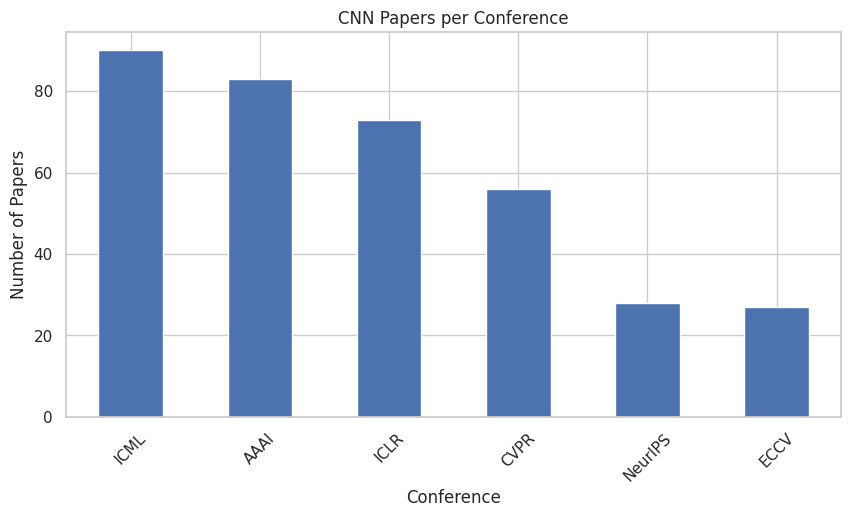

In [11]:
print("Total papers per conference:")
print(df['Conference Name'].value_counts())

# Optional: Bar plot
df['Conference Name'].value_counts().plot(kind='bar')
plt.title("CNN Papers per Conference")
plt.xlabel("Conference")
plt.ylabel("Number of Papers")
plt.xticks(rotation=45)
plt.show()


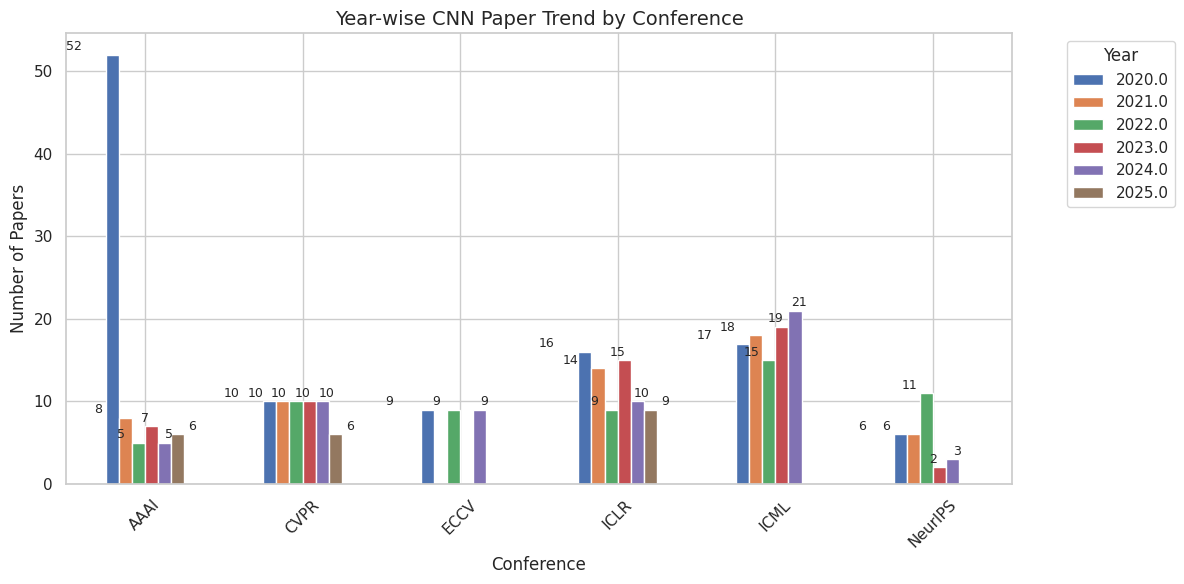

In [12]:
# Year-wise paper trend per conference with labels
import matplotlib.pyplot as plt
import seaborn as sns

# Group and pivot for plotting
trend = df.groupby(['Conference Name', 'Published Year']).size().unstack(fill_value=0)

# Plot setup
ax = trend.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title("Year-wise CNN Paper Trend by Conference", fontsize=14)
plt.ylabel("Number of Papers")
plt.xlabel("Conference")
plt.xticks(rotation=45)
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add number labels on bars
for i, conf in enumerate(trend.index):
    for j, year in enumerate(trend.columns):
        count = trend.loc[conf, year]
        if count > 0:
            ax.text(i + (j - len(trend.columns)/2) * 0.15, count + 0.2, str(count),
                    ha='center', va='bottom', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()


In [13]:
# Create the summary table: Conference × Year
year_conf_table = df.groupby(['Conference Name', 'Published Year']).size().unstack(fill_value=0)

# Display the table in Colab
from IPython.display import display
display(year_conf_table)


Published Year,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0
Conference Name,,,,,,
AAAI,52,8,5,7,5,6
CVPR,10,10,10,10,10,6
ECCV,9,0,9,0,9,0
ICLR,16,14,9,15,10,9
ICML,17,18,15,19,21,0
NeurIPS,6,6,11,2,3,0


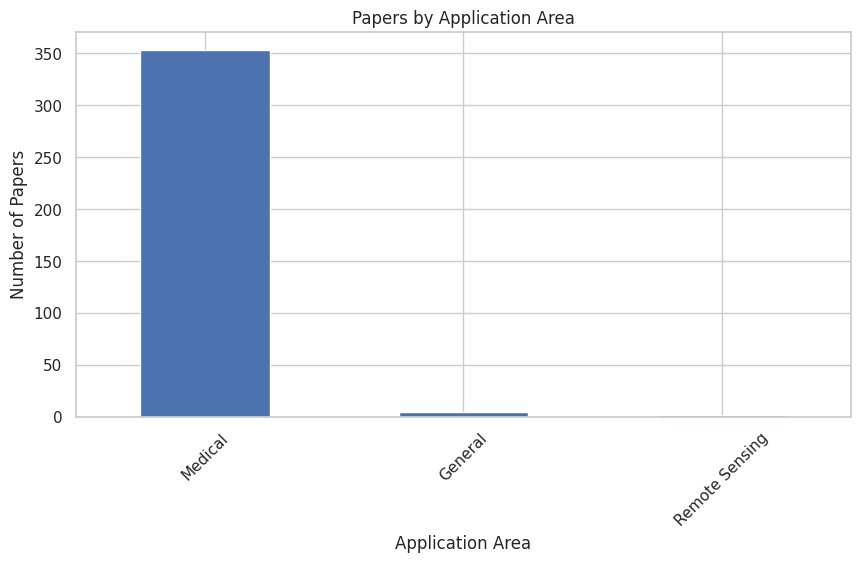

In [14]:
df['Application Area'].value_counts().plot(kind='bar')
plt.title("Papers by Application Area")
plt.xlabel("Application Area")
plt.ylabel("Number of Papers")
plt.xticks(rotation=45)
plt.show()


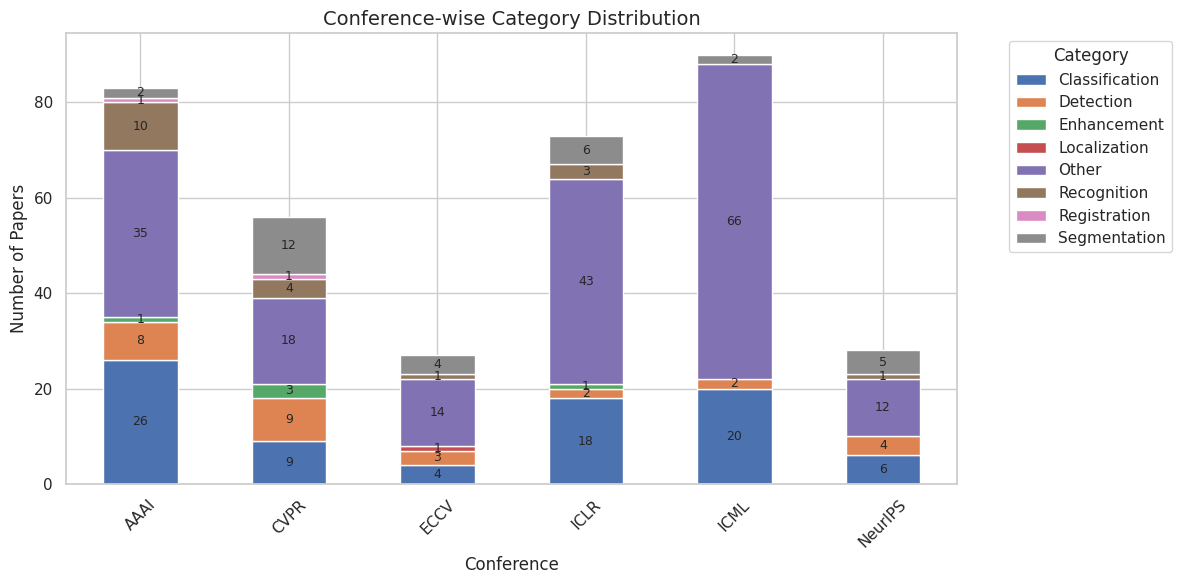

In [15]:
# Enhanced stacked bar plot for Conference-wise Category Distribution
import matplotlib.pyplot as plt

# Group and reshape
category_conf = df.groupby(['Conference Name', 'Category']).size().unstack(fill_value=0)

# Plot
ax = category_conf.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Conference-wise Category Distribution", fontsize=14)
plt.ylabel("Number of Papers")
plt.xlabel("Conference")
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add count labels to stacked bars
for i, conf in enumerate(category_conf.index):
    cumulative_height = 0
    for cat in category_conf.columns:
        count = category_conf.loc[conf, cat]
        if count > 0:
            ax.text(i, cumulative_height + count / 2, str(count),
                    ha='center', va='center', fontsize=9)
            cumulative_height += count

plt.tight_layout()
plt.show()


In [16]:
# Create the summary table for conference vs. category
category_table = df.groupby(['Conference Name', 'Category']).size().unstack(fill_value=0)

# Display the table in notebook
import pandas as pd
import IPython
from IPython.display import display

display(category_table)


Category,Classification,Detection,Enhancement,Localization,Other,Recognition,Registration,Segmentation
Conference Name,,,,,,,,
AAAI,26,8,1,0,35,10,1,2
CVPR,9,9,3,0,18,4,1,12
ECCV,4,3,0,1,14,1,0,4
ICLR,18,2,1,0,43,3,0,6
ICML,20,2,0,0,66,0,0,2
NeurIPS,6,4,0,0,12,1,0,5


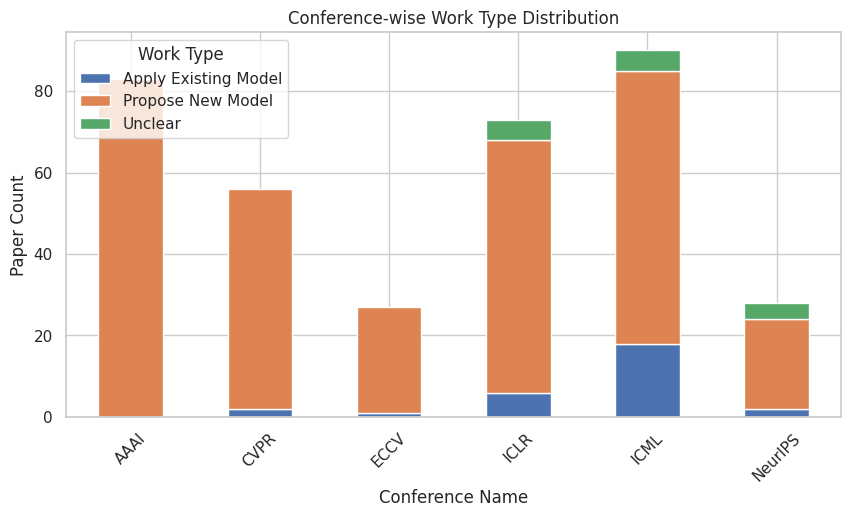

In [17]:
worktype_conf = df.groupby(['Conference Name', 'Work Type']).size().unstack(fill_value=0)
worktype_conf.plot(kind='bar', stacked=True)
plt.title("Conference-wise Work Type Distribution")
plt.ylabel("Paper Count")
plt.xticks(rotation=45)
plt.show()


In [18]:
# Create the summary table
worktype_table = df.groupby(['Conference Name', 'Work Type']).size().unstack(fill_value=0)

# Display the table in notebook
from IPython.display import display
display(worktype_table)


Work Type,Apply Existing Model,Propose New Model,Unclear
Conference Name,,,
AAAI,0,83,0
CVPR,2,54,0
ECCV,1,26,0
ICLR,6,62,5
ICML,18,67,5
NeurIPS,2,22,4


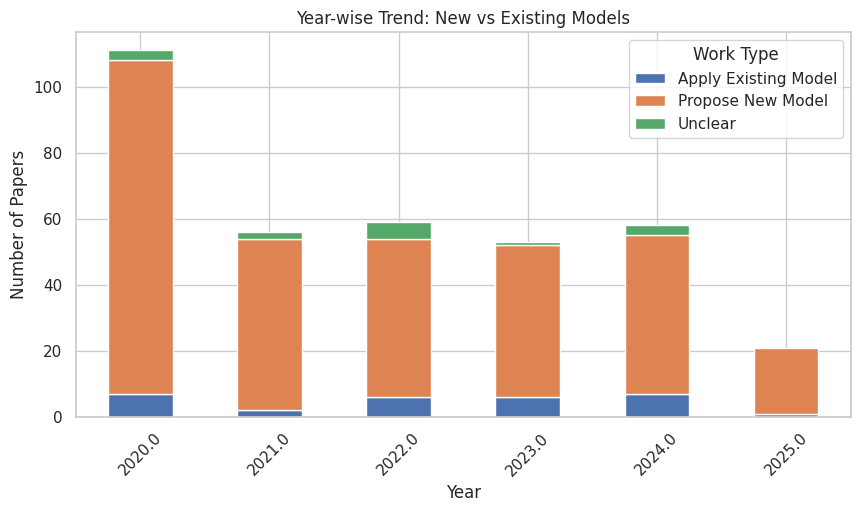

In [19]:
worktype_year = df.groupby(['Published Year', 'Work Type']).size().unstack(fill_value=0)
worktype_year.plot(kind='bar', stacked=True)
plt.title("Year-wise Trend: New vs Existing Models")
plt.ylabel("Number of Papers")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()


In [20]:
# Create the summary table for Year-wise Work Type Distribution
worktype_year_table = df.groupby(['Published Year', 'Work Type']).size().unstack(fill_value=0)

# Display the table nicely in notebook
from IPython.display import display
display(worktype_year_table)


Work Type,Apply Existing Model,Propose New Model,Unclear
Published Year,,,
2020.0,7,101,3
2021.0,2,52,2
2022.0,6,48,5
2023.0,6,46,1
2024.0,7,48,3
2025.0,1,20,0


Top Keywords in CNN Research:
convolutional    529
networks         457
neural           377
convolution      360
graph            341
cnn              335
based            302
network          289
model            282
cnns             276
performance      271
data             266
learning         263
image            263
training         259
dtype: int64


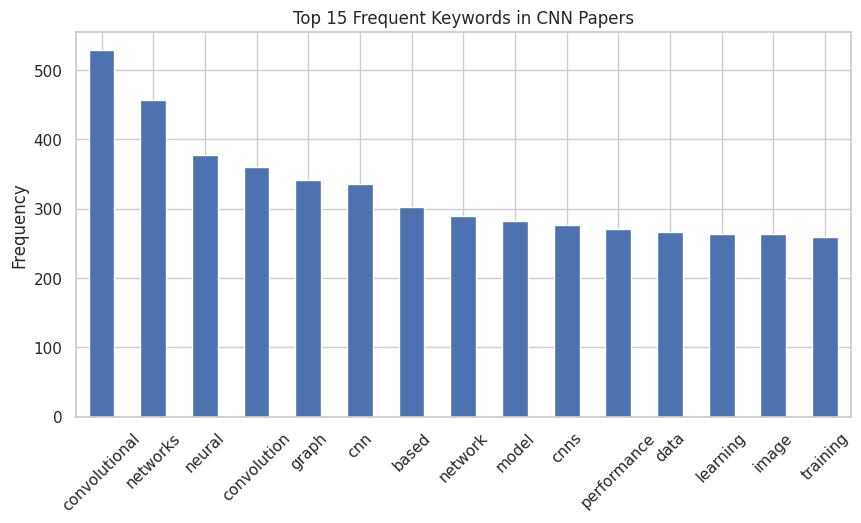

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', max_features=30)
X = cv.fit_transform(df['Full_Text'])
keywords = cv.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Show top keywords
keyword_freq = pd.Series(counts, index=keywords).sort_values(ascending=False)
print("Top Keywords in CNN Research:")
print(keyword_freq.head(15))

# Plot
keyword_freq.head(15).plot(kind='bar')
plt.title("Top 15 Frequent Keywords in CNN Papers")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


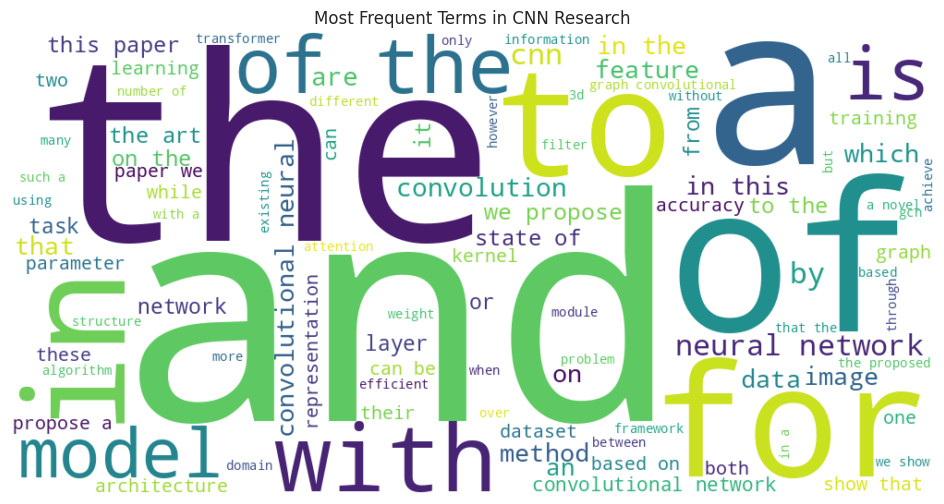

In [22]:
# Install wordcloud if not available
!pip install wordcloud

from wordcloud import WordCloud

# Combine all Full_Text entries into one string
text_data = ' '.join(df['Full_Text'].tolist())

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                      stopwords='english', max_words=100).generate(text_data)

# Show the word cloud
plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Terms in CNN Research")
plt.show()


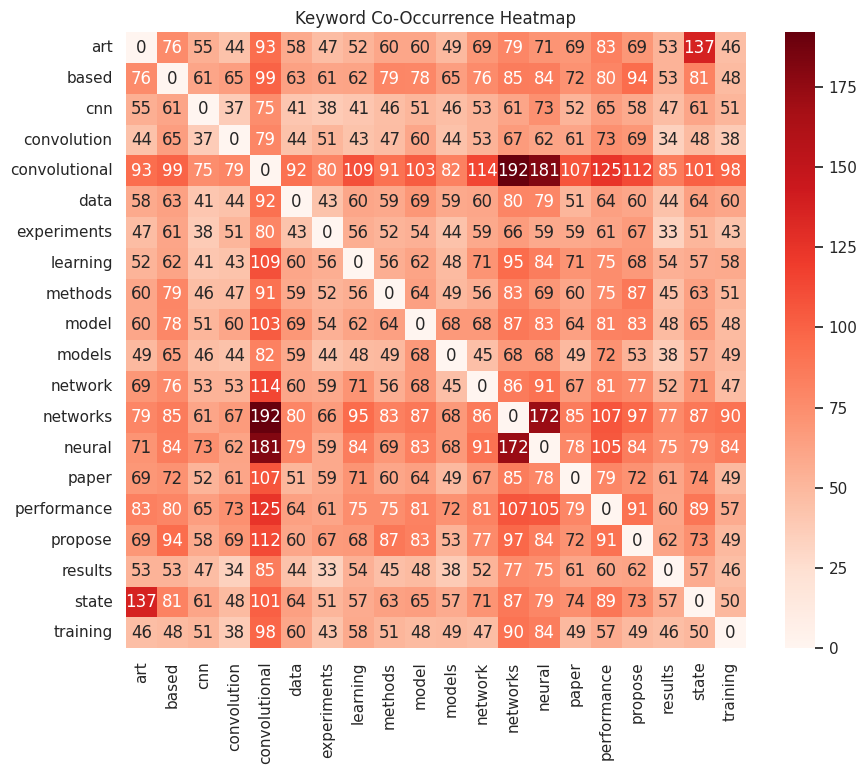

In [23]:
import numpy as np

# Vectorize the text to count keyword presence
cv = CountVectorizer(stop_words='english', max_features=20, binary=True)
X = cv.fit_transform(df['Full_Text'])

# Co-occurrence matrix
Xc = (X.T @ X)
Xc.setdiag(0)  # zero diagonal

# Convert to DataFrame
co_matrix = pd.DataFrame(Xc.toarray(), index=cv.get_feature_names_out(), columns=cv.get_feature_names_out())

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, cmap='Reds', annot=True, fmt='d')
plt.title("Keyword Co-Occurrence Heatmap")
plt.show()


# Generate Heatmap (Year × Conference)

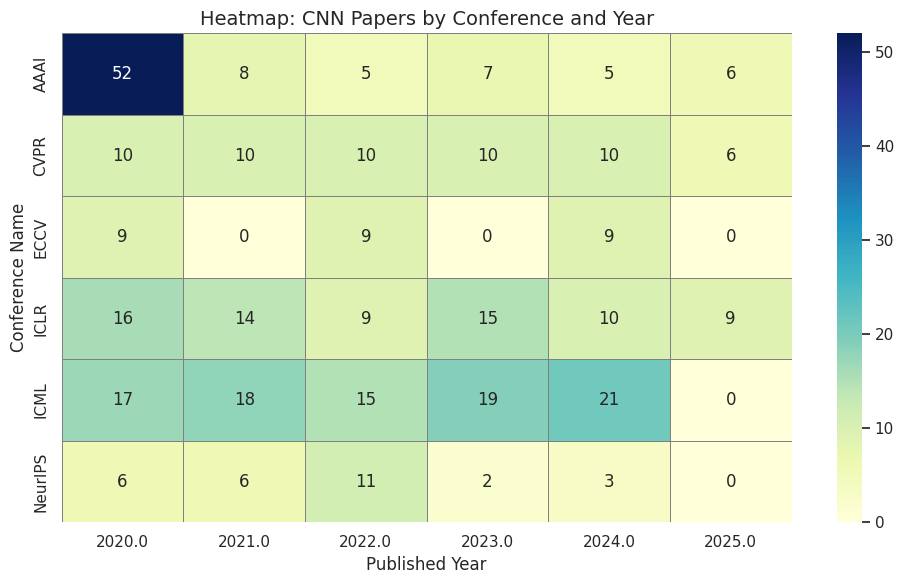

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the same table we generated before
year_conf_table = df.groupby(['Conference Name', 'Published Year']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(year_conf_table, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5, linecolor='gray')

plt.title("Heatmap: CNN Papers by Conference and Year", fontsize=14)
plt.ylabel("Conference Name")
plt.xlabel("Published Year")
plt.tight_layout()
plt.show()


In [25]:
# Count frequency of each model mentioned (from comma-separated values)
from collections import Counter

model_list = df['Mentioned Models'].dropna().tolist()
all_models = [model.strip() for entry in model_list if entry != 'N/A' for model in entry.split(',')]
model_counts = pd.Series(Counter(all_models)).sort_values(ascending=False)

print("Most Frequently Mentioned Models:")
display(model_counts)


Most Frequently Mentioned Models:


,0
resnet,43
convnext,11
mobilenet,9
vgg,7
densenet,3
alexnet,3
efficientnet,2
unet,1
fcn,1


In [26]:
# Count frequency of each dataset used
dataset_list = df['Datasets Used'].dropna().tolist()
all_datasets = [dataset.strip() for entry in dataset_list if entry != 'N/A' for dataset in entry.split(',')]
dataset_counts = pd.Series(Counter(all_datasets)).sort_values(ascending=False)

print("Most Frequently Used Datasets:")
display(dataset_counts)


Most Frequently Used Datasets:


,0
imagenet,42
cifar,27
coco,23
mnist,12
cityscapes,6
pascal voc,1
plant village,1


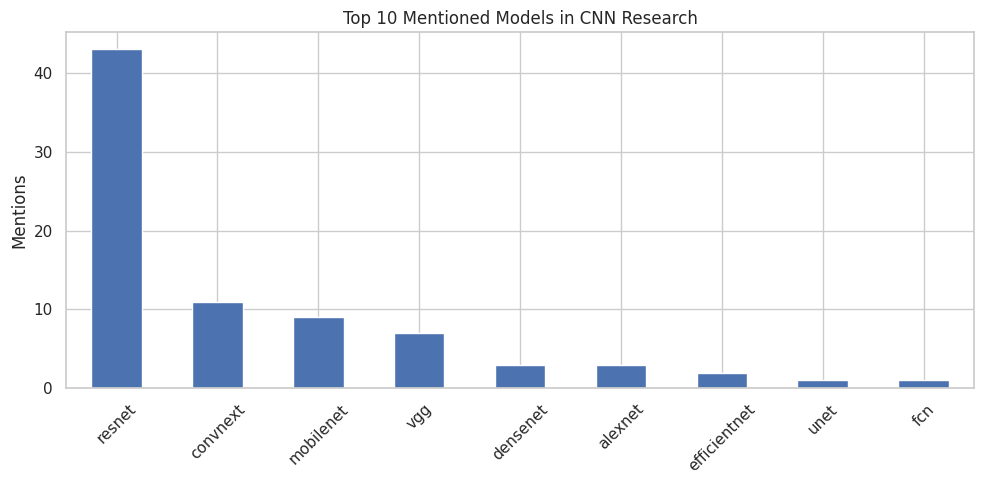

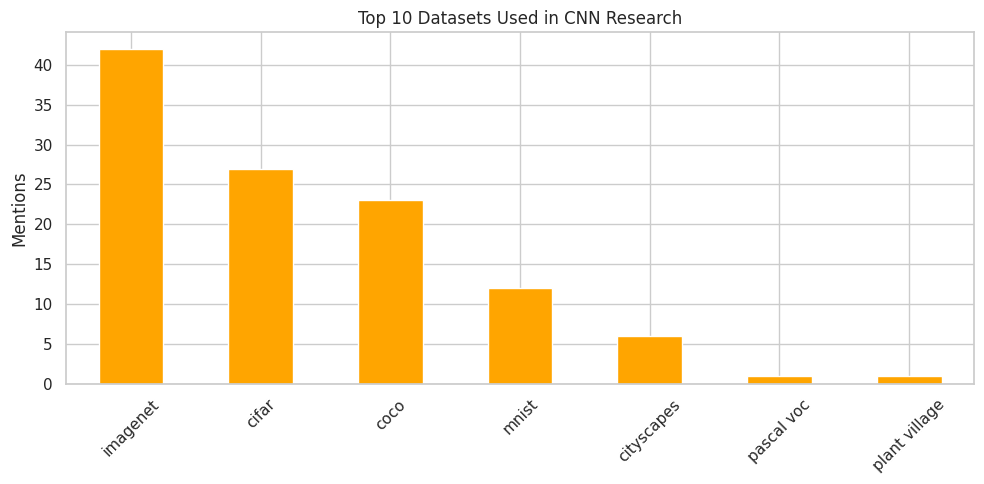

In [27]:
# Plot top 10 models
model_counts.head(10).plot(kind='bar', title='Top 10 Mentioned Models in CNN Research')
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot top 10 datasets
dataset_counts.head(10).plot(kind='bar', title='Top 10 Datasets Used in CNN Research', color='orange')
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
from collections import Counter
import pandas as pd

# Extract and count Mentioned Models
model_list = df['Mentioned Models'].dropna().tolist()
all_models = [model.strip() for entry in model_list if entry != 'N/A' for model in entry.split(',')]
model_counts = pd.Series(Counter(all_models)).sort_values(ascending=False)

# Extract and count Datasets Used
dataset_list = df['Datasets Used'].dropna().tolist()
all_datasets = [dataset.strip() for entry in dataset_list if entry != 'N/A' for dataset in entry.split(',')]
dataset_counts = pd.Series(Counter(all_datasets)).sort_values(ascending=False)

# Convert to DataFrames
top_models_df = model_counts.head(10).reset_index()
top_models_df.columns = ['Top Models', 'Count']

top_datasets_df = dataset_counts.head(10).reset_index()
top_datasets_df.columns = ['Top Datasets', 'Count']

# Combine into one table
combined_table = pd.concat([top_models_df, top_datasets_df], axis=1)

# Show in notebook
from IPython.display import display
display(combined_table)


,Top Models,Count,Top Datasets,Count
0,resnet,43,imagenet,42.0
1,convnext,11,cifar,27.0
2,mobilenet,9,coco,23.0
3,vgg,7,mnist,12.0
4,densenet,3,cityscapes,6.0
5,alexnet,3,pascal voc,1.0
6,efficientnet,2,plant village,1.0
7,unet,1,NaN,NaN
8,fcn,1,NaN,NaN


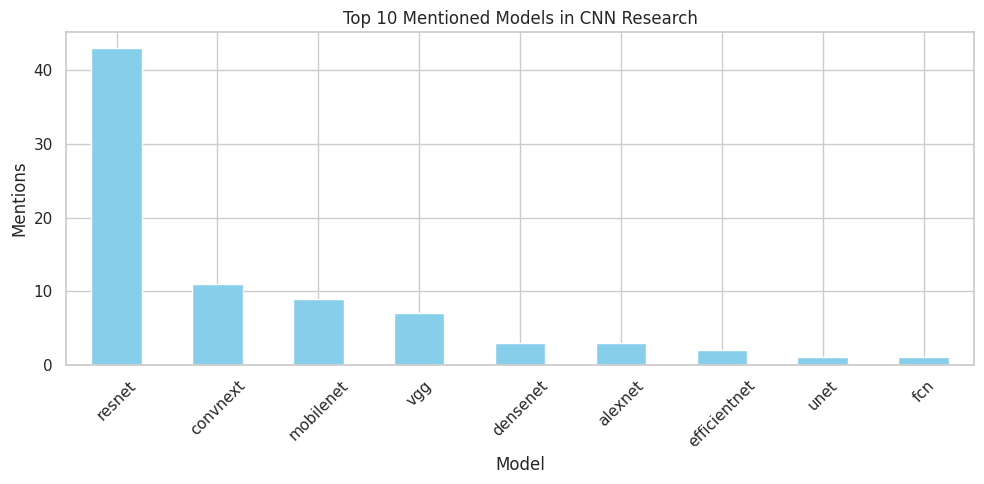

In [29]:
import matplotlib.pyplot as plt

# Plot Top 10 Models
model_counts.head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Mentioned Models in CNN Research")
plt.xlabel("Model")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


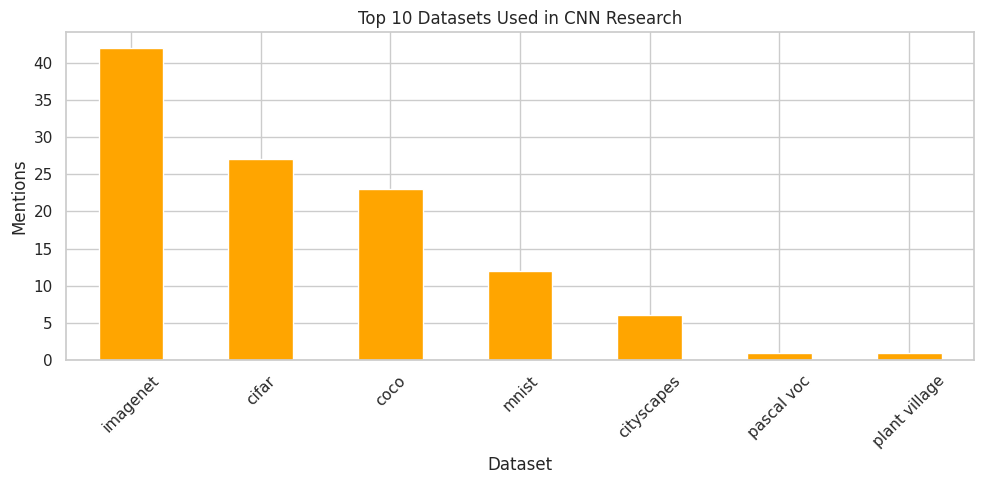

In [30]:
# Plot Top 10 Datasets
dataset_counts.head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Datasets Used in CNN Research")
plt.xlabel("Dataset")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
# Group by both Conference and Year along with Work Type
worktype_combo_table = df.groupby(['Conference Name', 'Published Year', 'Work Type']).size().unstack(fill_value=0)

# Optional: sort for better readability
worktype_combo_table = worktype_combo_table.sort_index()

# Display the combined table
from IPython.display import display
display(worktype_combo_table)


Work Type                       Apply Existing Model  Propose New Model  \
Conference Name Published Year                                            
AAAI            2020.0                             0                 52   
                2021.0                             0                  8   
                2022.0                             0                  5   
                2023.0                             0                  7   
                2024.0                             0                  5   
                2025.0                             0                  6   
CVPR            2020.0                             2                  8   
                2021.0                             0                 10   
                2022.0                             0                 10   
                2023.0                             0                 10   
                2024.0                             0                 10   
                2025.0                             0                  6   
ECCV            2020.0                             0                  9   
                2022.0                             0                  9   
                2024.0                             1                  8   
ICLR            2020.0                             1                 12   
                2021.0                             1                 12   
                2022.0                             1                  8   
                2023.0                             1                 14   
                2024.0                             1                  8   
                2025.0                             1                  8   
ICML            2020.0                             4                 13   
                2021.0                             1                 16   
                2022.0                             4                  9   
                2023.0                             5                 13   
                2024.0                             4                 16   
NeurIPS         2020.0                             0                  6   
                2021.0                             0                  6   
                2022.0                             1                  7   
                2023.0                             0                  2   
                2024.0                             1                  1   

Work Type                       Unclear  
Conference Name Published Year           
AAAI            2020.0                0  
                2021.0                0  
                2022.0                0  
                2023.0                0  
                2024.0                0  
                2025.0                0  
CVPR            2020.0                0  
                2021.0                0  
                2022.0                0  
                2023.0                0  
                2024.0                0  
                2025.0                0  
ECCV            2020.0                0  
                2022.0                0  
                2024.0                0  
ICLR            2020.0                3  
                2021.0                1  
                2022.0                0  
                2023.0                0  
                2024.0                1  
                2025.0                0  
ICML            2020.0                0  
                2021.0                1  
                2022.0                2  
                2023.0                1  
                2024.0                1  
NeurIPS         2020.0                0  
                2021.0                0  
                2022.0                3  
                2023.0                0  
                2024.0                1